In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras import layers
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1,EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

import os

# **Data Preperation**

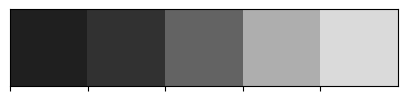

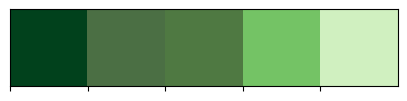

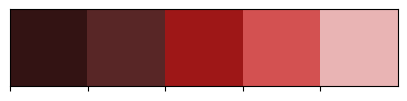

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
def crop_brain_contour(image, plot=False):

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)


    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')

        plt.show()

    return new_image


# **Experiments**



## **Steps**
1. Crop brain contunour
2. Split the dataset into train and test folder in 80:20 ratio
3. Generate augmented images for each class in train folder only
4. class folder name in both folder i.e. train and test should be glioma, meningioma, pituitary tumor


In [ ]:
labels = ['glioma','meningioma','pituitary tumor']

In [ ]:

X_train = []
y_train = []
X_test = []
y_test = []

print("Train Set")
print("===========")
image_size = 240
for i in labels:
  # path to the train folder
    folderPath = os.path.join('/content/drive/MyDrive/BrainTumorProject/Augmented+Split','train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)
##'/content/Augmented + Split'
print("Test Set")
print("=========")
for i in labels:
  # path to the test folder
    folderPath = os.path.join('/content/drive/MyDrive/BrainTumorProject/Cropped2','val',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_test.append(img)
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)


"""
import os
import cv2
import numpy as np
from tqdm import tqdm
import imutils  # <-- Added import for imutils

# Initialize lists
X_train = []
y_train = []
X_test = []
y_test = []

image_size = 240

# Function crop_brain_contour should be defined somewhere above
# Make sure it uses imutils.grab_contours correctly

print("Train Set")
print("===========")
for label in labels:
    folderPath = os.path.join('/content/drive/MyDrive/BrainTumorProject/Augmented+Split', 'train', label)
    for filename in tqdm(os.listdir(folderPath)):
        img_path = os.path.join(folderPath, filename)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Warning: Unable to read {img_path}")
            continue

        # Apply cropping
        img = crop_brain_contour(img)

        # Resize
        img = cv2.resize(img, (image_size, image_size))

        # Convert grayscale image back to 3 channels
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        X_train.append(img)
        y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

print("Test Set")
print("=========")
for label in labels:
    folderPath = os.path.join('/content/drive/MyDrive/BrainTumorProject/Cropped2', 'val', label)
    for filename in tqdm(os.listdir(folderPath)):
        img_path = os.path.join(folderPath, filename)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Warning: Unable to read {img_path}")
            continue

        # Apply cropping
        img = crop_brain_contour(img)

        # Resize
        img = cv2.resize(img, (image_size, image_size))

        # Convert grayscale image back to 3 channels
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        X_test.append(img)
        y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)

print("Data loading complete!")
print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")"""


Train Set


100%|██████████| 4215/4215 [01:38<00:00, 42.81it/s] 


Test Set


100%|██████████| 352/352 [00:07<00:00, 48.49it/s]


'\nimport os\nimport cv2\nimport numpy as np\nfrom tqdm import tqdm\nimport imutils  # <-- Added import for imutils\n\n# Initialize lists\nX_train = []\ny_train = []\nX_test = []\ny_test = []\n\nimage_size = 240\n\n# Function crop_brain_contour should be defined somewhere above\n# Make sure it uses imutils.grab_contours correctly\n\nprint("Train Set")\nprint("===========")\nfor label in labels:\n    folderPath = os.path.join(\'/content/drive/MyDrive/BrainTumorProject/Augmented+Split\', \'train\', label)\n    for filename in tqdm(os.listdir(folderPath)):\n        img_path = os.path.join(folderPath, filename)\n        img = cv2.imread(img_path)\n\n        if img is None:\n            print(f"Warning: Unable to read {img_path}")\n            continue\n\n        # Apply cropping\n        img = crop_brain_contour(img)\n\n        # Resize\n        img = cv2.resize(img, (image_size, image_size))\n\n        # Convert grayscale image back to 3 channels\n        if len(img.shape) == 2:\n        

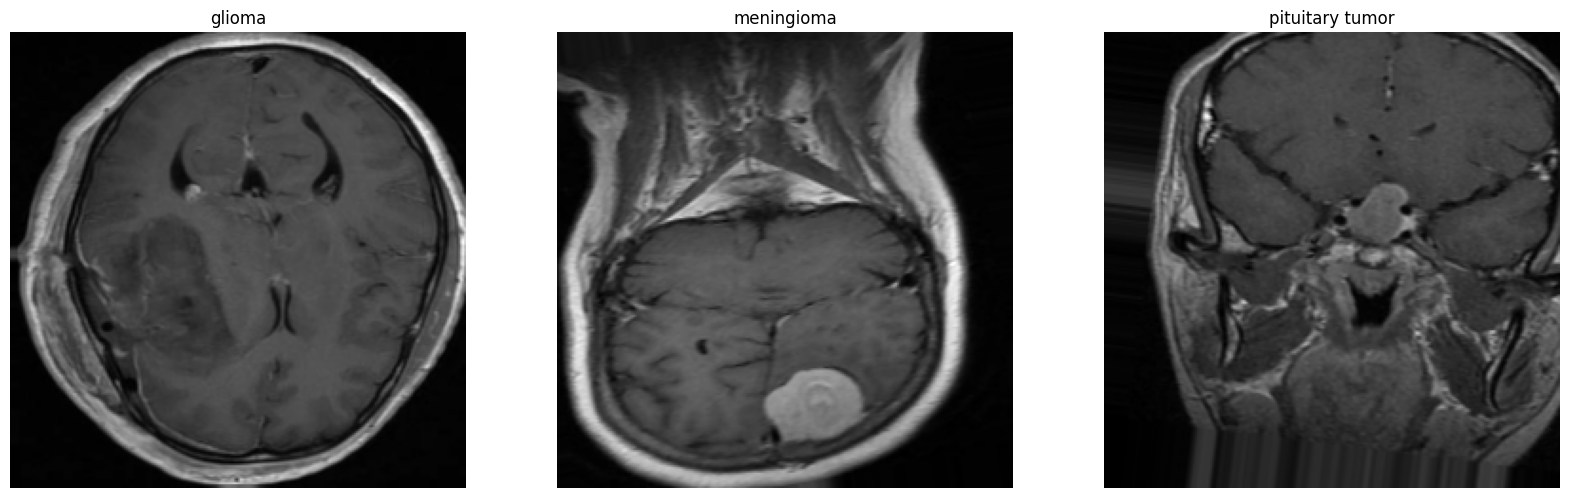

In [ ]:
# plot samples
k=0
fig, ax = plt.subplots(1,3,figsize=(20,20))

for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
# dataset shuffling
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_test, y_test = shuffle(X_test,y_test, random_state=101)

In [ ]:
X_train.shape

(12362, 240, 240, 3)

In [ ]:
print("x train=",X_train.shape)
print("y train=",y_train.shape)

print("x test=",X_test.shape)
print("y test=",y_test.shape)


x train= (12362, 240, 240, 3)
y train= (12362,)
x test= (1032, 240, 240, 3)
y test= (1032,)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<Axes: xlabel='count'>

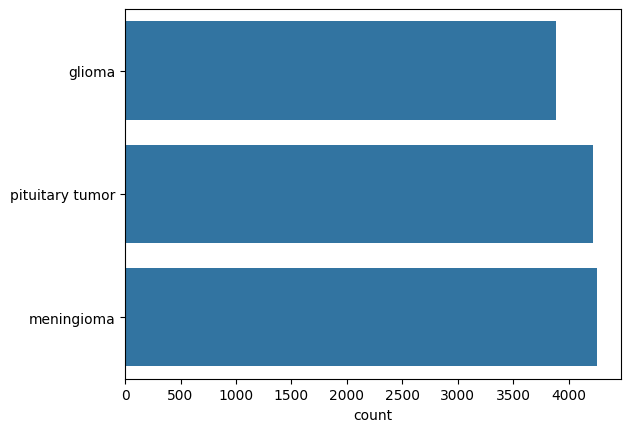

In [ ]:
sns.countplot(y_train)

<Axes: xlabel='count'>

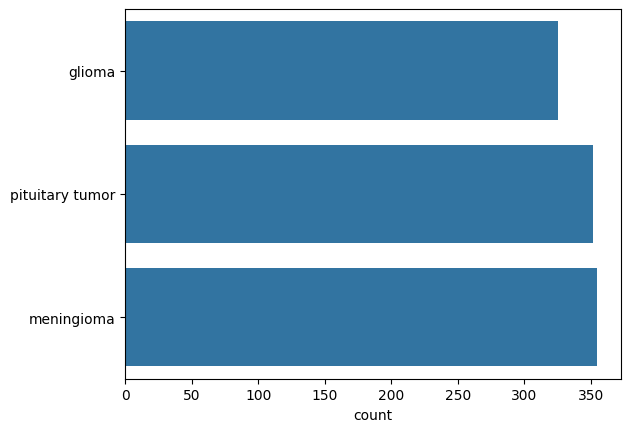

In [ ]:
sns.countplot(y_test)

In [ ]:
# label encoding

y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

## **EfficientNet B2**

### **Load Weights**

### **Transfer Learning**

In [ ]:
effnet = EfficientNetB2(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(3,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
## to be removed
print(X_train.min(), X_train.max())
print(X_test.min(), X_test.max())

0 255
1 250


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 240, 240,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 240, 240,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 240, 240,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 241, 241,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 120, 120,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 120, 120,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 120, 120,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 120, 120,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 120, 120,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 120, 120,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 120, 120,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 120, 120,  │        512 │ block1a_se_excit

 Total params: 7,772,796 (29.65 MB)

 Trainable params: 7,705,221 (29.39 MB)

 Non-trainable params: 67,575 (263.97 KB)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("/content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)

### **Training The Model**

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.8928 - loss: 0.2975
Epoch 1: val_accuracy improved from -inf to 0.96443, saving model to /content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 280s 462ms/step - accuracy: 0.8929 - loss: 0.2972 - val_accuracy: 0.9644 - val_loss: 0.1102 - learning_rate: 0.0010
Epoch 2/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9748 - loss: 0.0722
Epoch 2: val_accuracy did not improve from 0.96443
348/348 ━━━━━━━━━━━━━━━━━━━━ 103s 212ms/step - accuracy: 0.9748 - loss: 0.0721 - val_accuracy: 0.7559 - val_loss: 2.0650 - learning_rate: 0.0010
Epoch 3/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9784 - loss: 0.0643
Epoch 3: val_accuracy did not improve from 0.96443
348/348 ━━━━━━━━━━━━━━━━━━━━ 74s 212ms/step - accuracy: 0.9784 - loss: 0.0643 - val_accuracy: 0.9555 - val_loss: 0.1222 - learning_rate: 0.0010
Epoch 4/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9827 - loss: 0.0495
Epoch 4: val_accuracy improved from 0.96443 to 0.98707, saving model to /content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 77s 220ms/step - accuracy: 0.9827 - loss: 0.0495 - val_accuracy: 0.9871 - val_loss: 0.0375 - learning_rate: 0.0010
Epoch 5/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.9900 - loss: 0.0301
Epoch 5: val_accuracy did not improve from 0.98707
348/348 ━━━━━━━━━━━━━━━━━━━━ 74s 214ms/step - accuracy: 0.9900 - loss: 0.0301 - val_accuracy: 0.9838 - val_loss: 0.0505 - learning_rate: 0.0010
Epoch 6/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9916 - loss: 0.0262
Epoch 6: val_accuracy did not improve from 0.98707
348/348 ━━━━━━━━━━━━━━━━━━━━ 74s 212ms/step - accuracy: 0.9916 - loss: 0.0263 - val_accuracy: 0.9798 - val_loss: 0.0554 - learning_rate: 0.0010
Epoch 7/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9955 - loss: 0.0169
Epoch 7: val_accuracy did not improve from 0.98707
348/348 ━━━━━━━━━━━━━━━━━━━━ 74s 213ms/step - accuracy: 0.9955 - loss: 0.0170 - val_accuracy: 0.9717 - val_loss: 0.1177 - learning_rate: 0.0010
Epoch 8

348/348 ━━━━━━━━━━━━━━━━━━━━ 77s 221ms/step - accuracy: 0.9914 - loss: 0.0256 - val_accuracy: 0.9895 - val_loss: 0.0562 - learning_rate: 0.0010
Epoch 9/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9888 - loss: 0.0347
Epoch 9: val_accuracy did not improve from 0.98949
348/348 ━━━━━━━━━━━━━━━━━━━━ 74s 213ms/step - accuracy: 0.9888 - loss: 0.0347 - val_accuracy: 0.9887 - val_loss: 0.0317 - learning_rate: 0.0010
Epoch 10/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9960 - loss: 0.0119
Epoch 10: val_accuracy improved from 0.98949 to 0.99030, saving model to /content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 77s 221ms/step - accuracy: 0.9960 - loss: 0.0119 - val_accuracy: 0.9903 - val_loss: 0.0329 - learning_rate: 0.0010
Epoch 11/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9919 - loss: 0.0247
Epoch 11: val_accuracy did not improve from 0.99030
348/348 ━━━━━━━━━━━━━━━━━━━━ 74s 213ms/step - accuracy: 0.9919 - loss: 0.0247 - val_accuracy: 0.9863 - val_loss: 0.0512 - learning_rate: 0.0010
Epoch 12/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9946 - loss: 0.0169
Epoch 12: val_accuracy did not improve from 0.99030
348/348 ━━━━━━━━━━━━━━━━━━━━ 82s 212ms/step - accuracy: 0.9946 - loss: 0.0169 - val_accuracy: 0.9733 - val_loss: 0.1040 - learning_rate: 0.0010
Epoch 13/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9951 - loss: 0.0161
Epoch 13: val_accuracy did not improve from 0.99030

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
348/348 ━━━━━━━━━━━━━━━━━━━━ 74s 212ms/step - accuracy: 0.9951 - lo

348/348 ━━━━━━━━━━━━━━━━━━━━ 77s 220ms/step - accuracy: 0.9937 - loss: 0.0218 - val_accuracy: 0.9919 - val_loss: 0.0406 - learning_rate: 3.0000e-04
Epoch 15/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9993 - loss: 0.0022
Epoch 15: val_accuracy improved from 0.99192 to 0.99596, saving model to /content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 77s 221ms/step - accuracy: 0.9993 - loss: 0.0022 - val_accuracy: 0.9960 - val_loss: 0.0446 - learning_rate: 3.0000e-04
Epoch 16/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 1.0000 - loss: 5.0874e-04
Epoch 16: val_accuracy did not improve from 0.99596
348/348 ━━━━━━━━━━━━━━━━━━━━ 74s 213ms/step - accuracy: 1.0000 - loss: 5.0836e-04 - val_accuracy: 0.9960 - val_loss: 0.0514 - learning_rate: 3.0000e-04
Epoch 17/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9999 - loss: 7.8867e-04
Epoch 17: val_accuracy did not improve from 0.99596
348/348 ━━━━━━━━━━━━━━━━━━━━ 74s 212ms/step - accuracy: 0.9999 - loss: 7.8873e-04 - val_accuracy: 0.9951 - val_loss: 0.0543 - learning_rate: 3.0000e-04
Epoch 18/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9999 - loss: 0.0013
Epoch 18: val_accuracy did not improve from 0.99596
348/348 ━━━━━━━━━━━━━━━━━━━━ 74s 212ms/step - accuracy: 0.9999 - loss: 0.0013 - val_accuracy: 0.9943 - val_loss: 0.05

348/348 ━━━━━━━━━━━━━━━━━━━━ 78s 226ms/step - accuracy: 0.9997 - loss: 0.0019 - val_accuracy: 0.9968 - val_loss: 0.0330 - learning_rate: 9.0000e-05
Epoch 22/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9995 - loss: 0.0014
Epoch 22: val_accuracy did not improve from 0.99677
348/348 ━━━━━━━━━━━━━━━━━━━━ 75s 214ms/step - accuracy: 0.9995 - loss: 0.0014 - val_accuracy: 0.9968 - val_loss: 0.0292 - learning_rate: 9.0000e-05
Epoch 23/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9998 - loss: 0.0011
Epoch 23: val_accuracy did not improve from 0.99677
348/348 ━━━━━━━━━━━━━━━━━━━━ 74s 212ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 0.9960 - val_loss: 0.0327 - learning_rate: 9.0000e-05
Epoch 24/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 1.0000 - loss: 1.5794e-04
Epoch 24: val_accuracy did not improve from 0.99677
348/348 ━━━━━━━━━━━━━━━━━━━━ 74s 212ms/step - accuracy: 1.0000 - loss: 1.5837e-04 - val_accuracy: 0.9968 - val_loss: 0.0324 - lea

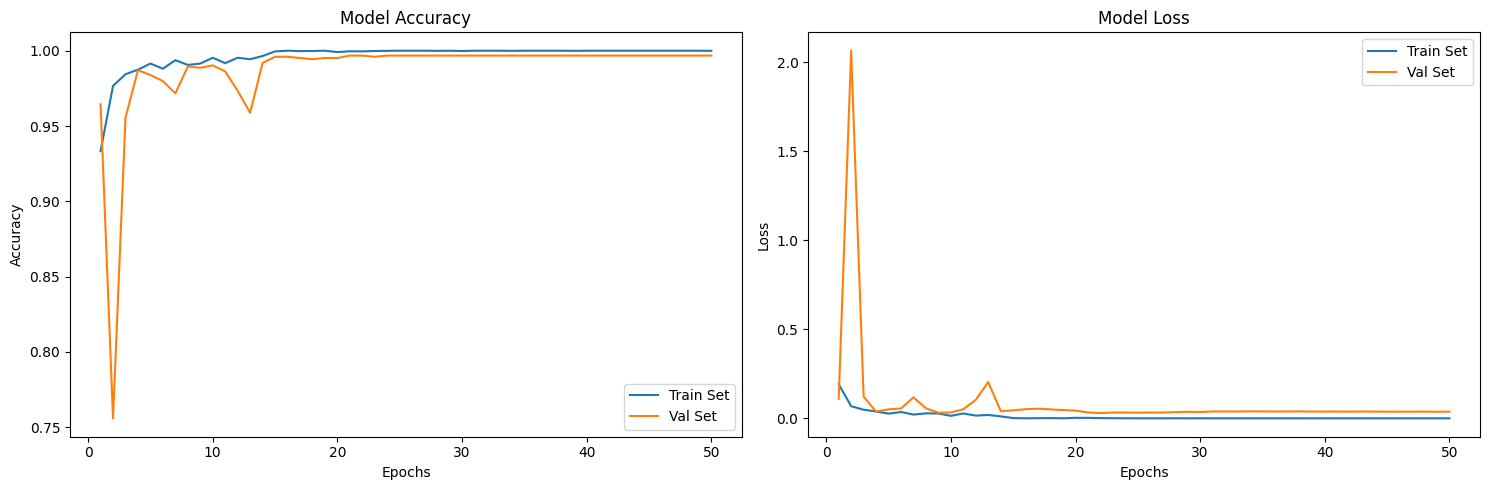

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

### **Prediction**

In [ ]:
models = load_model('/content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2.h5')
pred = models.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 560ms/step


In [ ]:
loss,acc = models.evaluate(X_test,y_test,verbose = 1)
print("Test Accuracy: ",np.round(acc*100,2))

33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 226ms/step - accuracy: 0.9909 - loss: 0.0332
Test Accuracy:  98.74


In [ ]:
print(classification_report(y_test_new,pred,target_names = labels,digits = 4))

                 precision    recall  f1-score   support

         glioma     0.9876    0.9785    0.9830       325
     meningioma     0.9859    0.9831    0.9845       355
pituitary tumor     0.9888    1.0000    0.9944       352

       accuracy                         0.9874      1032
      macro avg     0.9874    0.9872    0.9873      1032
   weighted avg     0.9874    0.9874    0.9874      1032



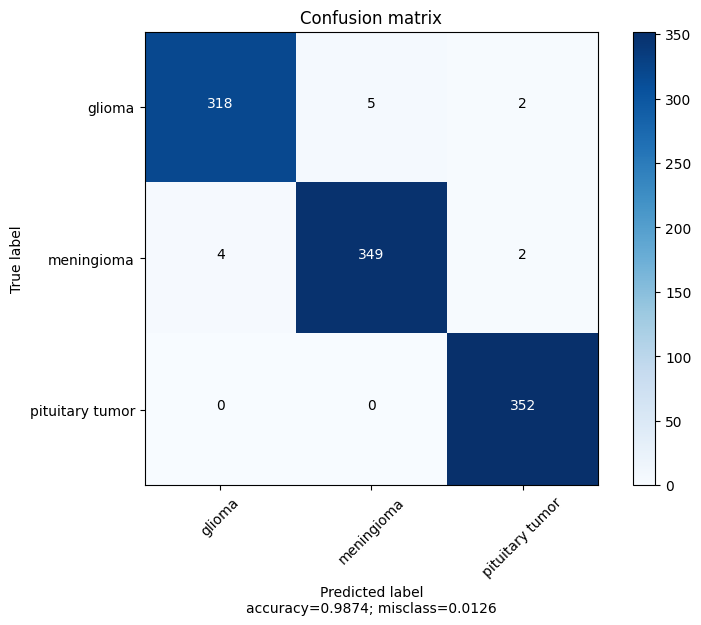

In [ ]:
confusion_mtx = confusion_matrix(y_test_new,pred)
cm = plot_confusion_matrix(confusion_mtx, target_names = labels, normalize=False)

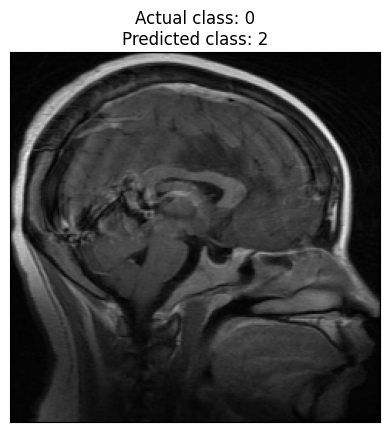

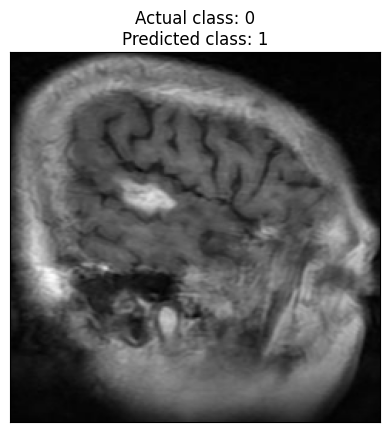

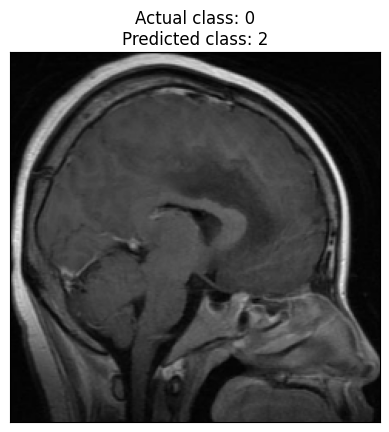

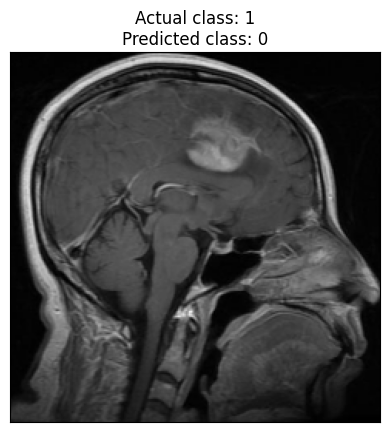

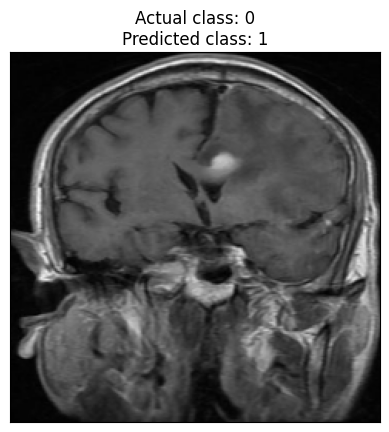

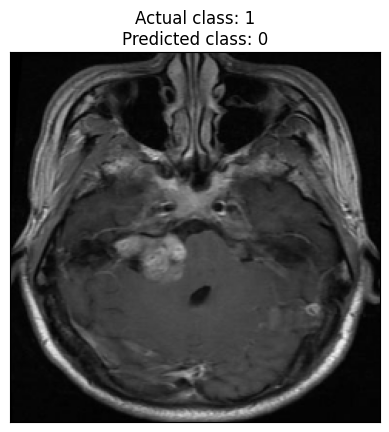

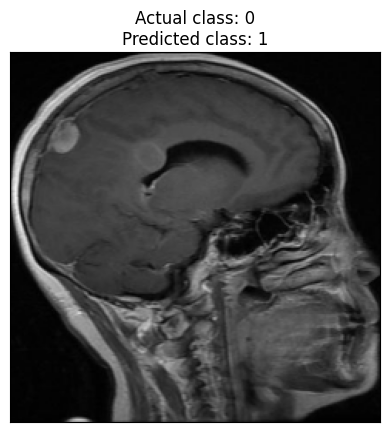

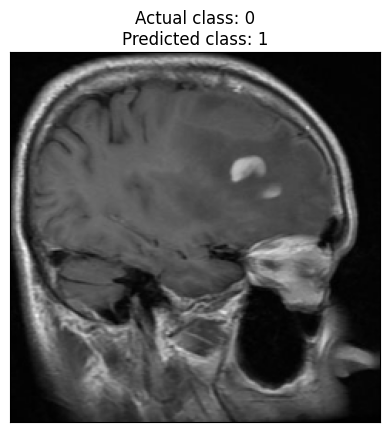

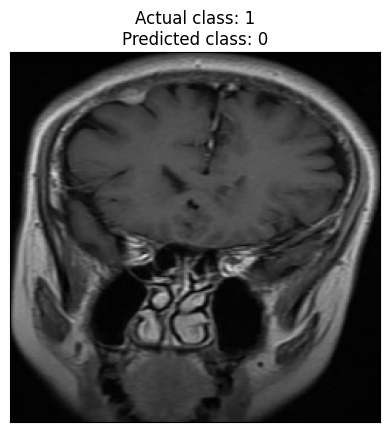

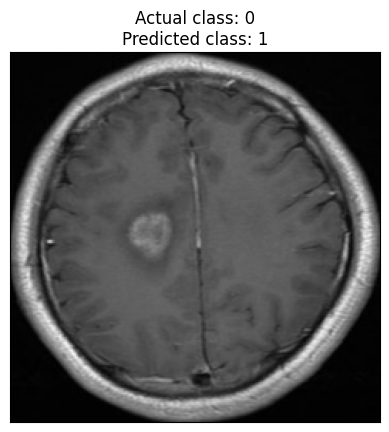

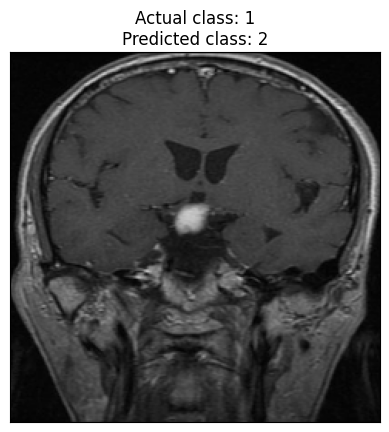

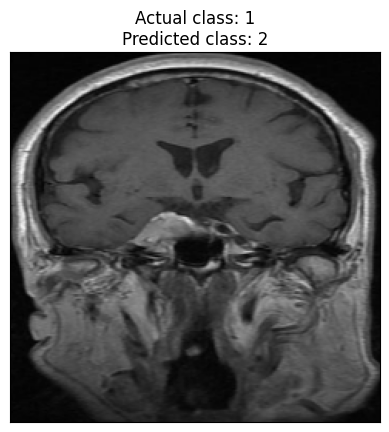

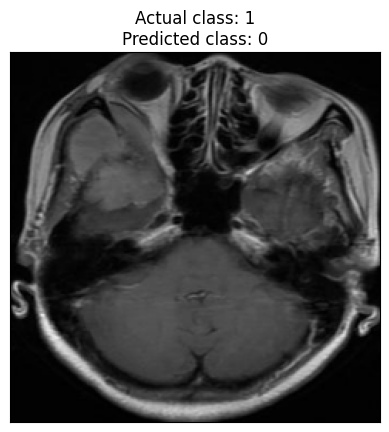

In [ ]:
ind_list = np.argwhere((y_test_new == pred) == False)[:, -1]
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_test_new[i]}\nPredicted class: {pred[i]}')
        plt.show()

# **HYBIRED CNN (CODE HERE ) With CBAM**

In [ ]:
effnetry = EfficientNetB2(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
"""model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(3,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)"""

In [ ]:
def transformer_encoder(x, num_heads=2, key_dim=16, ff_dim=64):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = layers.Add()([x, attn])
    x = layers.LayerNormalization()(x)

    ffn = layers.Dense(ff_dim, activation="relu")(x)
    ffn = layers.Dense(x.shape[-1])(ffn)
    x = layers.Add()([x, ffn])
    x = layers.LayerNormalization()(x)
    return x



In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, max_len=1000, embed_dim=256):
        super().__init__()
        self.max_len = max_len
        self.embed_dim = embed_dim
        self.pos_embedding = layers.Embedding(input_dim=max_len, output_dim=embed_dim)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        positions = tf.range(seq_len)
        pos_embed = self.pos_embedding(positions)
        return x + pos_embed


In [ ]:
from tensorflow.keras import layers
import tensorflow as tf

class CBAM(layers.Layer):
    def __init__(self, reduction_ratio=16):
        super(CBAM, self).__init__()
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        channel = input_shape[-1]
        # MLP for channel attention
        self.shared_mlp = tf.keras.Sequential([
            layers.Dense(channel // self.reduction_ratio, activation='relu'),
            layers.Dense(channel)
        ])
        # Conv for spatial attention
        self.spatial_conv = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')

    def call(self, x):
        #Channel Attention
        avg_pool = layers.GlobalAveragePooling2D()(x)
        max_pool = layers.GlobalMaxPooling2D()(x)
        avg_out = self.shared_mlp(avg_pool)
        max_out = self.shared_mlp(max_pool)
        channel_attn = layers.Activation('sigmoid')(avg_out + max_out)
        channel_attn = layers.Reshape((1,1,x.shape[-1]))(channel_attn)
        x = layers.Multiply()([x, channel_attn])

        # Spatial Attention
        avg_pool_spatial = layers.Lambda(lambda z: tf.reduce_mean(z, axis=-1, keepdims=True))(x)
        max_pool_spatial = layers.Lambda(lambda z: tf.reduce_max(z, axis=-1, keepdims=True))(x)
        concat = layers.Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
        spatial_attn = self.spatial_conv(concat)
        x = layers.Multiply()([x, spatial_attn])

        return x


In [ ]:
from tensorflow.keras import layers, Model
import tensorflow as tf
x = effnetry.output
x = layers.Conv2D(256, 1)(x)
x = CBAM()(x)
x = layers.Reshape((-1, 256))(x)
x = PositionalEmbedding(max_len=1000, embed_dim=256)(x)
x = transformer_encoder(x, num_heads=2, key_dim=16, ff_dim=64)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(3, activation='softmax')(x)


modeltry = Model(inputs=effnetry.input, outputs=output)


In [ ]:
modeltry.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 240, 240,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 240, 240,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 240, 240,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 241, 241,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 120, 120,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 120, 120,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 120, 120,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 120, 120,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 120, 120,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 120, 120,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 120, 120,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 120, 120,  │        512 │ block1a_se_excit

 Total params: 8,461,839 (32.28 MB)

 Trainable params: 8,394,264 (32.02 MB)

 Non-trainable params: 67,575 (263.97 KB)

In [ ]:
#modeltry.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])
modeltry.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),  # better LR
    metrics=['accuracy']
)


In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("/content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2HypEFFwithCBAM.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)

Training model:

In [ ]:
"""history = modeltry.fit(X_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])"""
history = modeltry.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[tensorboard, checkpoint, reduce_lr]
)


Epoch 1/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.6865 - loss: 0.6935
Epoch 1: val_accuracy improved from -inf to 0.76556, saving model to /content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2HypEFFwithCBAM.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 301s 496ms/step - accuracy: 0.6868 - loss: 0.6928 - val_accuracy: 0.7656 - val_loss: 0.5267 - learning_rate: 3.0000e-05
Epoch 2/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9343 - loss: 0.1839
Epoch 2: val_accuracy improved from 0.76556 to 0.92967, saving model to /content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2HypEFFwithCBAM.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 81s 232ms/step - accuracy: 0.9343 - loss: 0.1839 - val_accuracy: 0.9297 - val_loss: 0.1688 - learning_rate: 3.0000e-05
Epoch 3/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9680 - loss: 0.0914
Epoch 3: val_accuracy improved from 0.92967 to 0.98060, saving model to /content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2HypEFFwithCBAM.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 82s 235ms/step - accuracy: 0.9680 - loss: 0.0913 - val_accuracy: 0.9806 - val_loss: 0.0534 - learning_rate: 3.0000e-05
Epoch 4/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9844 - loss: 0.0491
Epoch 4: val_accuracy improved from 0.98060 to 0.99192, saving model to /content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2HypEFFwithCBAM.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 83s 238ms/step - accuracy: 0.9844 - loss: 0.0491 - val_accuracy: 0.9919 - val_loss: 0.0289 - learning_rate: 3.0000e-05
Epoch 5/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9908 - loss: 0.0295
Epoch 5: val_accuracy improved from 0.99192 to 0.99353, saving model to /content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2HypEFFwithCBAM.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 85s 245ms/step - accuracy: 0.9908 - loss: 0.0295 - val_accuracy: 0.9935 - val_loss: 0.0219 - learning_rate: 3.0000e-05
Epoch 6/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9935 - loss: 0.0200
Epoch 6: val_accuracy did not improve from 0.99353
348/348 ━━━━━━━━━━━━━━━━━━━━ 78s 224ms/step - accuracy: 0.9935 - loss: 0.0200 - val_accuracy: 0.9935 - val_loss: 0.0192 - learning_rate: 3.0000e-05
Epoch 7/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9936 - loss: 0.0167
Epoch 7: val_accuracy improved from 0.99353 to 0.99596, saving model to /content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2HypEFFwithCBAM.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 85s 243ms/step - accuracy: 0.9936 - loss: 0.0167 - val_accuracy: 0.9960 - val_loss: 0.0139 - learning_rate: 3.0000e-05
Epoch 8/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9954 - loss: 0.0130
Epoch 8: val_accuracy improved from 0.99596 to 0.99677, saving model to /content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2HypEFFwithCBAM.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 86s 247ms/step - accuracy: 0.9954 - loss: 0.0130 - val_accuracy: 0.9968 - val_loss: 0.0175 - learning_rate: 3.0000e-05
Epoch 9/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9978 - loss: 0.0079
Epoch 9: val_accuracy did not improve from 0.99677
348/348 ━━━━━━━━━━━━━━━━━━━━ 78s 224ms/step - accuracy: 0.9978 - loss: 0.0079 - val_accuracy: 0.9943 - val_loss: 0.0199 - learning_rate: 3.0000e-05
Epoch 10/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9978 - loss: 0.0075
Epoch 10: val_accuracy improved from 0.99677 to 0.99757, saving model to /content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2HypEFFwithCBAM.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 84s 241ms/step - accuracy: 0.9978 - loss: 0.0075 - val_accuracy: 0.9976 - val_loss: 0.0118 - learning_rate: 3.0000e-05
Epoch 11/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9977 - loss: 0.0068
Epoch 11: val_accuracy did not improve from 0.99757
348/348 ━━━━━━━━━━━━━━━━━━━━ 78s 224ms/step - accuracy: 0.9977 - loss: 0.0068 - val_accuracy: 0.9960 - val_loss: 0.0129 - learning_rate: 3.0000e-05
Epoch 12/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9985 - loss: 0.0051
Epoch 12: val_accuracy did not improve from 0.99757
348/348 ━━━━━━━━━━━━━━━━━━━━ 78s 223ms/step - accuracy: 0.9985 - loss: 0.0051 - val_accuracy: 0.9960 - val_loss: 0.0168 - learning_rate: 3.0000e-05
Epoch 13/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9984 - loss: 0.0051
Epoch 13: val_accuracy did not improve from 0.99757
348/348 ━━━━━━━━━━━━━━━━━━━━ 78s 223ms/step - accuracy: 0.9984 - loss: 0.0051 - val_accuracy: 0.9960 - val_loss: 0.0139 - learning_ra


Epoch 25: ReduceLROnPlateau reducing learning rate to 8.099999604382901e-07.
348/348 ━━━━━━━━━━━━━━━━━━━━ 80s 231ms/step - accuracy: 0.9996 - loss: 0.0011 - val_accuracy: 0.9984 - val_loss: 0.0094 - learning_rate: 2.7000e-06
Epoch 26/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9996 - loss: 0.0014
Epoch 26: val_accuracy did not improve from 0.99838
348/348 ━━━━━━━━━━━━━━━━━━━━ 78s 223ms/step - accuracy: 0.9996 - loss: 0.0014 - val_accuracy: 0.9984 - val_loss: 0.0099 - learning_rate: 8.1000e-07
Epoch 27/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9992 - loss: 0.0019
Epoch 27: val_accuracy did not improve from 0.99838
348/348 ━━━━━━━━━━━━━━━━━━━━ 77s 222ms/step - accuracy: 0.9992 - loss: 0.0019 - val_accuracy: 0.9984 - val_loss: 0.0094 - learning_rate: 8.1000e-07
Epoch 28/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9997 - loss: 0.0012
Epoch 28: val_accuracy did not improve from 0.99838
348/348 ━━━━━━━━━━━━━━━━━━━━ 77s 222ms/step - accuracy:

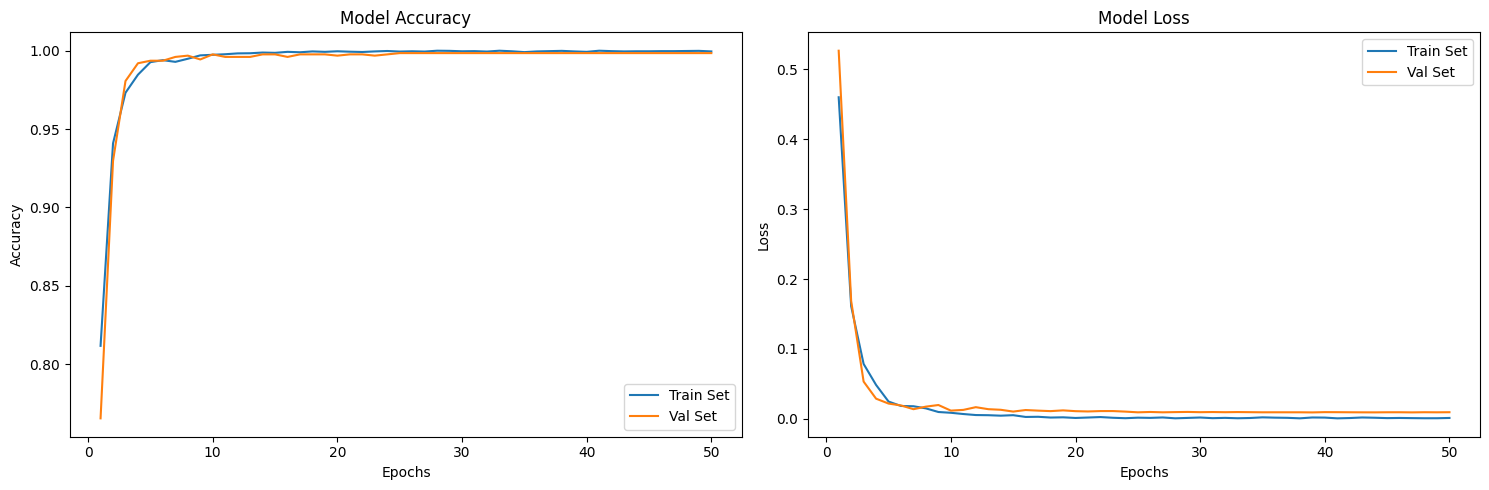

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

## **Predection**

In [ ]:

pred = modeltry.predict(X_test)
pred = np.argmax(pred, axis=1)
y_test_new = np.argmax(y_test, axis=1)



33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 617ms/step


In [ ]:
loss,acc = modeltry.evaluate(X_test,y_test,verbose = 1)
print("Test Accuracy: ",np.round(acc*100,2))

33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 278ms/step - accuracy: 0.9906 - loss: 0.0473
Test Accuracy:  98.64


In [ ]:
print(classification_report(y_test_new,pred,target_names = labels,digits = 4))

                 precision    recall  f1-score   support

         glioma     0.9969    0.9815    0.9891       325
     meningioma     0.9777    0.9859    0.9818       355
pituitary tumor     0.9859    0.9915    0.9887       352

       accuracy                         0.9864      1032
      macro avg     0.9868    0.9863    0.9865      1032
   weighted avg     0.9865    0.9864    0.9864      1032



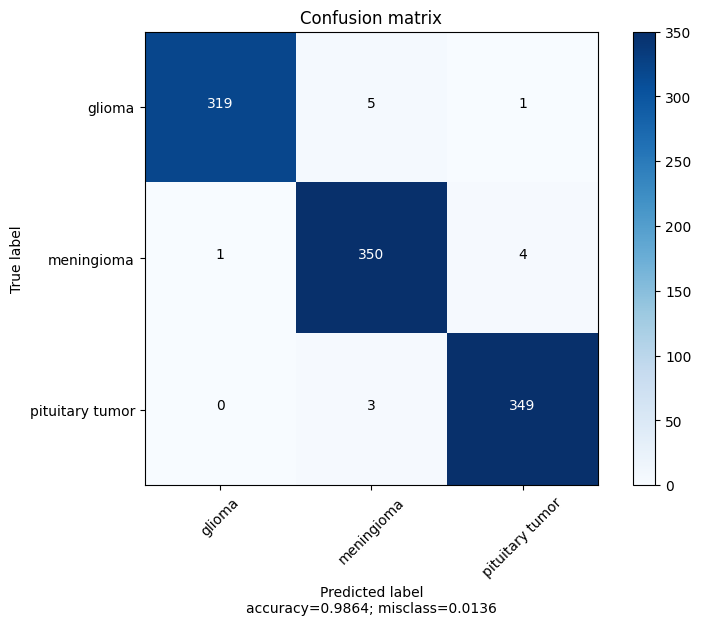

In [ ]:
confusion_mtx = confusion_matrix(y_test_new,pred)
cm = plot_confusion_matrix(confusion_mtx, target_names = labels, normalize=False)

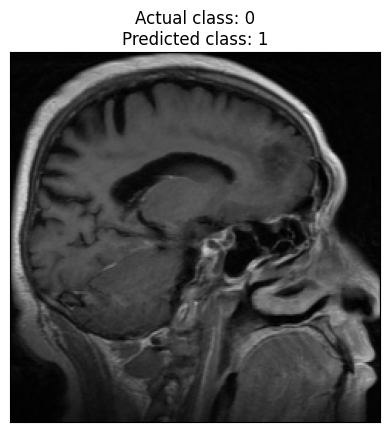

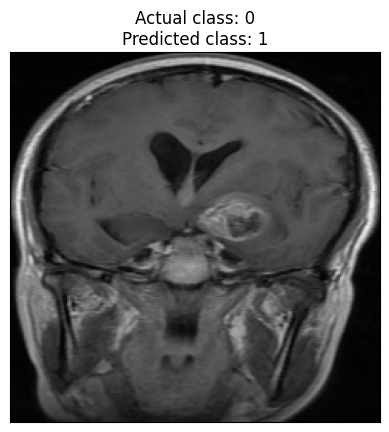

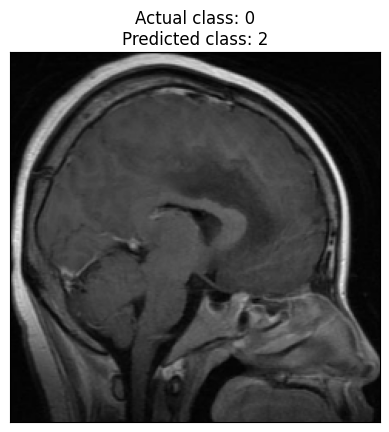

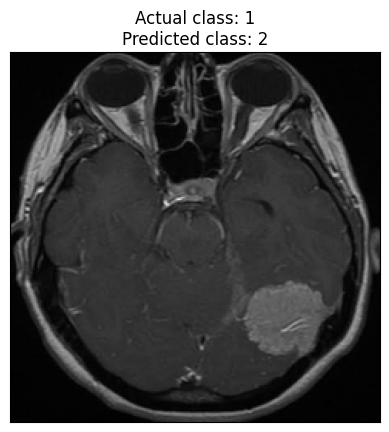

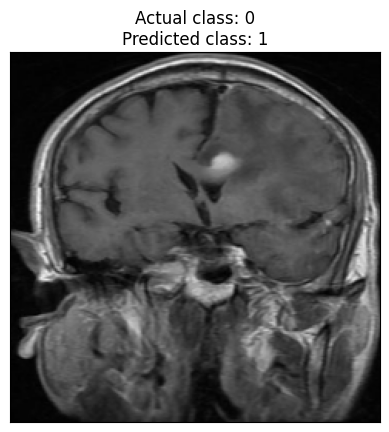

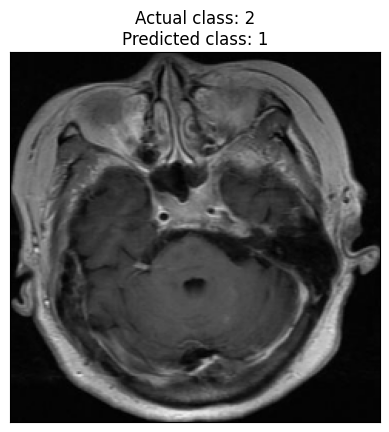

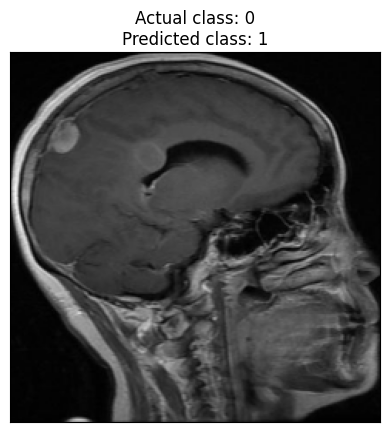

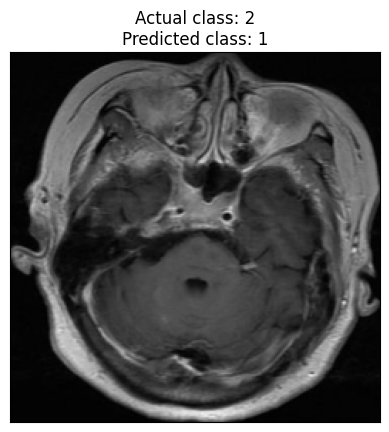

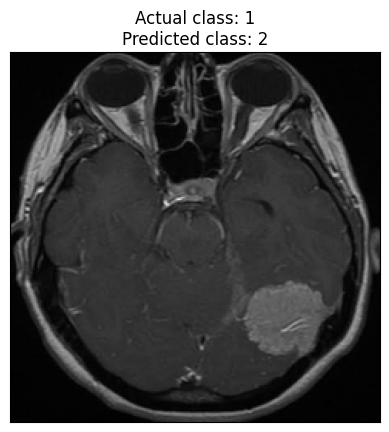

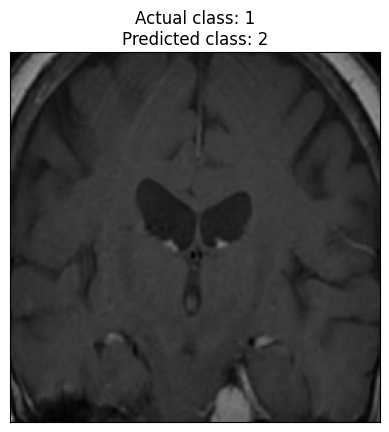

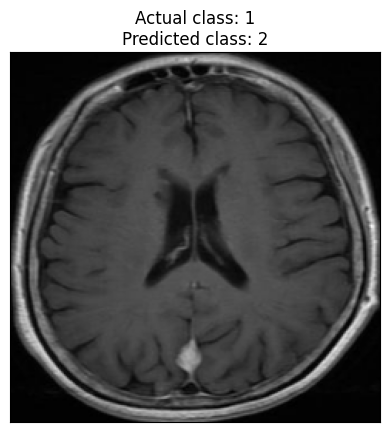

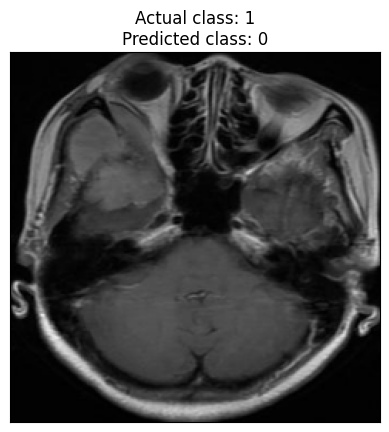

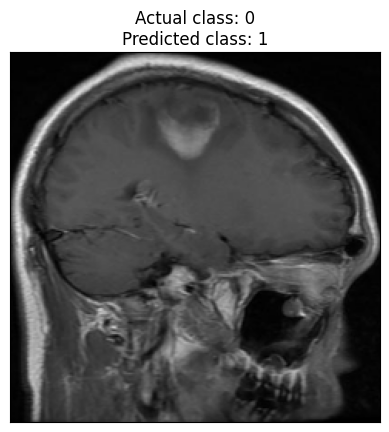

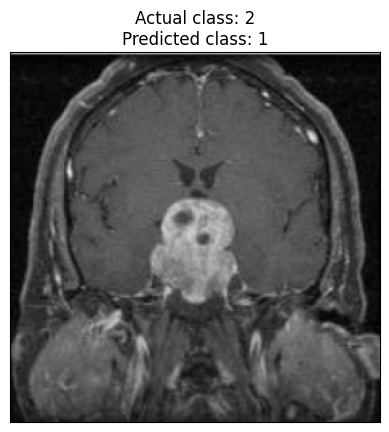

In [ ]:
ind_list = np.argwhere((y_test_new == pred) == False)[:, -1]
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_test_new[i]}\nPredicted class: {pred[i]}')
        plt.show()

DONE